# Predicting Wine Taste Quality

# Scenario 2: No Outliers Removed

### This is a supplemental notebook for alternate code results, and is not a complete version of the project.  For the complete version, see Wine_Taste_Quality.ipynb

Importing Modules

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from sklearn.cross_validation import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.grid_search import GridSearchCV
import statsmodels.api as sm
from functools import partial
%matplotlib inline

Functions

In [2]:
def predict(x_i, beta):
    return np.dot(x_i, beta)

def regr_error(x_i, y_i, beta):
    return y_i - predict(x_i, beta)

def calc_pred_vals(list_of_rows, list_of_betas, intercept=0):
    pred_vals = []
    for i in range(len(list_of_rows)):
        pred_val = intercept + predict(list_of_rows[i], list_of_betas)
        pred_vals.append(pred_val)
    return pred_vals

# rmse calculation
def calc_rmse(preds, target):
    errors, squared_error = [], []
    for i in range(len(target)):
        errors.append(target[i] - preds[i])
    for error in errors:
        squared_error.append(error**2)
    mse = sum(squared_error)/len(squared_error)
    rmse = np.sqrt(mse)
    return rmse

# convert continous values to discrete
def round_prediction(predicted_values):
    preds = []
    for i in range(len(predicted_values)):
        pred_val = predicted_values[i]
        if pred_val < 0.5: preds.append(0)
        elif pred_val >= 0.5 and pred_val < 1.5: preds.append(1)
        elif pred_val >= 1.5 and pred_val < 2.5: preds.append(2)
        elif pred_val >= 2.5 and pred_val < 3.5: preds.append(3)
        elif pred_val >= 3.5 and pred_val < 4.5: preds.append(4)
        elif pred_val >= 4.5 and pred_val < 5.5: preds.append(5)
        elif pred_val >= 5.5 and pred_val < 6.5: preds.append(6)
        elif pred_val >= 6.5 and pred_val < 7.5: preds.append(7)
        elif pred_val >= 7.5 and pred_val < 8.5: preds.append(8)
        elif pred_val >= 8.5 and pred_val < 9.5: preds.append(9)
        elif pred_val >= 9.5: preds.append(10)
        else: print 'check predicted value'
    return preds

#return a list of list of confusion matrix entries
def confusion_entries(num_rows, preds, targets):
    A = [[0 for j in range(num_rows)] for i in range(num_rows)]
    #outer loop iterates through each target and prediction 
    for i in range(len(targets)): 
        pred, target = preds[i], targets[i]
        #inner loop iterates through each cell in the confusion matrix
        for j in range(num_rows): 
            for k in range(num_rows):
                #there will be one match in each inner iteration
                if target==j and pred==k: 
                    #increment value in cell when match is found
                    A[j][k] += 1  
    return A

# create dataframe for model coefficients
def make_df(betas, attributes, ix, intercept=0):
    new_beta_list, new_columns = [], []
    new_columns.append('intercept')
    new_beta_list.append(round(intercept, 5))
    for i in range(len(betas)):
        new_columns.append(attributes[i])
        beta = betas[i]
        new_beta_list.append(round(beta, 5))
    new_df = pd.DataFrame(new_beta_list, index=new_columns, columns=ix).T
    return new_df

# return requested columns of dataset - used in stepwise algorithm
def x_features_cols(dataset, features):
    x_out = []
    for row in dataset:
        x_out.append([row[i] for i in features])
    return(x_out)

# scale a row of features' values given as input for a predicted value
# receive 3 lists (row of inputs, original means & stds for each feature)
def scale_vals(row, orig_mean, orig_std):
    scaled_row = []
    for i in range(len(row)):
        scaled_value = (row[i] - orig_mean[i]) / orig_std[i]
        scaled_row.append(scaled_value)
    return scaled_row

#used in minimization function
def in_random_order(data):    
    indexes = [i for i, _ in enumerate(data)]
    random.shuffle(indexes)
    for i in indexes: 
        yield data[i]

Functions (cont'd)

In [3]:
def model_details(name, preds, betas, intercept, feat_seq, targets, calc_acc=True):
    
    model_name = []     
    model_name.append(name) # name must be in list format; df col gets transformed to index
    modl_name.append(name) # global variable
    
    # store rms error
    rms_error = calc_rmse(preds, targets)
    rmse.append(rms_error)
    
    # store dataframe of model's beta coefficients 
    df_coeff = make_df(betas, feat_seq, model_name, intercept)
    df_beta_coefs.append(df_coeff) 
    
    # calculate accuracy & store confusion matrix, unless labels are scaled
    if calc_acc:
        actual_ix = ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10']
        pred_ix = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']
        rounded_preds = round_prediction(preds)
        con_mat = confusion_entries(len(pred_ix), rounded_preds, targets)
        cmat = pd.DataFrame(con_mat, index=actual_ix, columns=pred_ix)
        #delete columns with no results, eg, taste quality: 0, 1, 2, 9 & 10 are zero
        del cmat['P0']; del cmat['P1']; del cmat['P2']; del cmat['P9']; del cmat['P10']
        cmat = cmat.ix[3:] # delete rows 0, 1 & 2
        cmat = cmat.ix[:6] # delete last 2 rows
        #add column for row total
        cmat['Total']=cmat['P3']+cmat['P4']+cmat['P5']+cmat['P6']+cmat['P7']+cmat['P8']
        #denominator should equal total number of rows in dataset)
        sum_total = cmat['Total'].sum()
        # add along diagonal for true positives (numerator) 
        tp = cmat.iloc[0]['P3']+cmat.iloc[1]['P4']+cmat.iloc[2]['P5']+cmat.iloc[3]['P6'] +\
        cmat.iloc[4]['P7'] + cmat.iloc[5]['P8']
        acc = tp / sum_total  # accuracy is true positives divided by the sum total
        cmats.append(cmat)
        cmat_sum.append(sum_total)
        accuracy.append(acc)        
    else:
        cmats.append('n/a, labels are scaled')
        cmat_sum.append('n/a, labels are scaled')
        accuracy.append('n/a, labels are scaled')

Load Dataset into DataFrame

In [4]:
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv")
df = pd.read_csv(target_url, header=0, sep=";")
print 'df.shape', df.shape
df.head()

df.shape (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Rename Columns

In [5]:
df.columns = ['fixed acidity (0)', 'volatile acidity (1)', 'citric acid (2)', 
              'residual sugar (3)', 'chlorides (4)', 'free sulfur dioxide (5)', 
              'total sulfur dioxide (6)', 'density (7)', 'pH (8)', 'sulphates (9)', 
              'alcohol (10)', 'target']
df.head()

,fixed acidity (0),volatile acidity (1),citric acid (2),residual sugar (3),chlorides (4),free sulfur dioxide (5),total sulfur dioxide (6),density (7),pH (8),sulphates (9),alcohol (10),target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Calculating Outliers

In [12]:
#removed

Ordinary Least Squares Model Summary with Stats

In [8]:
x = df[list(df.columns)[:-1]]
y = df['target']
x = sm.add_constant(x)  #include intercept, since x is not scaled
modl = sm.OLS(y, x).fit()  #y goes before x in statsmodels
modl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Sun, 27 Nov 2016   Prob (F-statistic):          1.79e-145
Time:                        01:16:10   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:                    1587   BIC:                             3227.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
const                       21.9652     21.195      1.036      0.300       -19.607    63.538
fixed acidity (0)            0.0250      0.026      0.963      0.336        -0.026     0.076
volatile acidity (1)        -1.0836      0.121     -8.948      0.000        -1.321    -0.846
citric acid (2)             -0.1826      0.147     -1.240      0.215        -0.471     0.106
residual sugar (3)           0.0163      0.015      1.089      0.276        -0.013     0.046
chlorides (4)               -1.8742      0.419     -4.470      0.000        -2.697    -1.052
free sulfur dioxide (5)      0.0044      0.002      2.009      0.045         0.000     0.009
total sulfur dioxide (6)    -0.0033      0.001     -4.480      0.000        -0.005    -0.002
density (7)                -17.8812     21.633     -0.827      0.409       -60.314    24.551
pH (8)                      -0.4137      0.192     -2.159      0.031        -0.789    -0.038
sulphates (9)                0.9163      0.114      8.014      0.000         0.692     1.141
alcohol (10)                 0.2762      0.026     10.429      0.000         0.224     0.328
==============================================================================
Omnibus:                       27.376   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.965
Skew:                          -0.168   Prob(JB):                     1.27e-09
Kurtosis:                       3.708   Cond. No.                     1.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Additional data formats needed for some algorithms

In [9]:
# 11 features, excluding labels, in list of lists format
x_list = np.array(df[list(df.columns)[:-1]]).tolist()

# labels in list format
labels = df['target'].tolist()

# 12 features, scaled
dfvals = df.values
data_scaled = StandardScaler().fit_transform(dfvals)

# 11 features, scaled, in dataframe format
# lables, scaled, in list format
df_scaled = pd.DataFrame(data_scaled, columns=df.columns)
labels_scaled = df_scaled['target'].tolist()
del df_scaled['target']

# 11 features, scaled, in list of lists format
x_scaled = np.array(df_scaled).tolist()

Value Counts for Wine Taste Quality (note: 1, 2, 9 & 10 are zero)

In [10]:
df.target.value_counts() 

5    681
6    638
7    199
4     53
8     18
3     10
Name: target, dtype: int64

## Models & Algorithms

1.  Stepwise Algorithm <br>
2.  Stepwise Regression 7 features <br>
3.  Linear Regression 11 features <br>
4.  Lars Algorithm <br>
5.  Lars, xy scaled <br>
6.  Lasso, alphas, sklearn <br>
7.  Lasso alpha 0.01, sklearn, xy scaled <br> 
8.  Lasso alpha 0.01, sklearn, x scaled <br> 
9.  Gradient Descent, from scratch, x scaled <br>
10. Gradient Descent, sklearn, x scaled <br>
11. Gradient Descent 7 features, from scratch, x scaled <br>
12. Gradient Descent 7 features, sklearn, x scaled  <br>
13. Ridge, alphas, from scratch, x scaled <br>
14. Ridge, alphas, sklearn <br>
15. Ridge alpha .0001, from scratch, x scaled <br> 
16. Ridge alpha 1, sklearn <br>
17. ElasticNet grid search for L1 ratio

#### 1. Stepwise Algorithm 

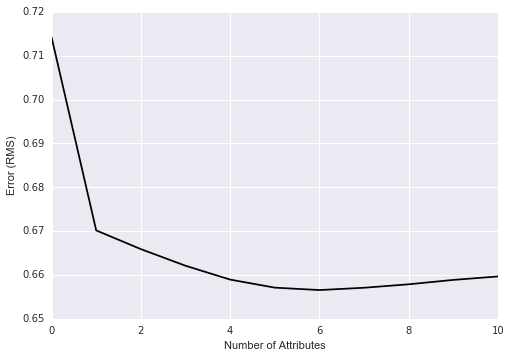

Out of sample error versus attribute set size
[0.71422610507564765, 0.67015915718770025, 0.6658948255733077, 0.66210322905841368, 0.65894318547313158, 0.65710566704274365, 0.65655619653940922, 0.65708294716302151, 0.65787039535648484, 0.65887165001454129, 0.65966046088820485]

Best attribute indices
[10, 1, 9, 4, 6, 8, 5, 2, 3, 7, 0]

Best attribute names
['alcohol (10)', 'volatile acidity (1)', 'sulphates (9)', 'chlorides (4)', 'total sulfur dioxide (6)', 'pH (8)', 'free sulfur dioxide (5)', 'citric acid (2)', 'residual sugar (3)', 'density (7)', 'fixed acidity (0)']

Rmse Results of Forward Stepwise Regression


,alcohol (10),volatile acidity (1),sulphates (9),chlorides (4),total sulfur dioxide (6),pH (8),free sulfur dioxide (5),citric acid (2),residual sugar (3),density (7),fixed acidity (0)
RMSE,0.714226,0.670159,0.665895,0.662103,0.658943,0.657106,0.656556,0.657083,0.65787,0.658872,0.65966


In [11]:
#index list positions 
index_positions = range(len(x_list))
x_list_ = [x_list[i] for i in index_positions]
y_ = [labels[i] for i in index_positions]

#try each feature to see which one gives least oos error
stepwise_indices = []
indx = range(len(x_list_[1]))
index_set = set(indx)
oos_error = []
for i in indx:
    feature_set = set(stepwise_indices)
    try_set = index_set - feature_set
    try_list = [i for i in try_set]  
    error_list, temp_list = [], []
    for feat in try_list:  
        temp_list = [] + stepwise_indices
        temp_list.append(feat)
        xTemp = x_features_cols(x_list_, temp_list) #add next feature to dataset
        x_ = np.array(xTemp); y_ = np.array(y_)  #convert to numpy arrays
        modl = LinearRegression()  
        modl.fit(x_, y_)
        step_preds = cross_val_predict(modl, x_, y_, cv=10) #make predictions
        rms_error = calc_rmse(step_preds, y_)  #calculate errors
        error_list.append(rms_error)
        temp_list = []
    iBest = np.argmin(error_list)
    stepwise_indices.append(try_list[iBest])
    oos_error.append(error_list[iBest])
    
#plot error versus number of attributes
xaxis = range(len(oos_error))
plt.plot(xaxis, oos_error, 'k')
plt.xlabel('Number of Attributes')
plt.ylabel('Error (RMS)')
plt.show()

print('Out of sample error versus attribute set size')
print(oos_error)
print('\nBest attribute indices')
print(stepwise_indices)
stepwise_sequence = [df.columns[i] for i in stepwise_indices]
print('\nBest attribute names')
print(stepwise_sequence)
oos_rounded = []
for i in oos_error:
    oos_rounded.append(round(i,7))
df_features = pd.DataFrame(zip(oos_rounded), index = stepwise_sequence, columns = ['RMSE'])
print '\nRmse Results of Forward Stepwise Regression'
df_features.T

#### 2. Stepwise Regression 7 features

In [12]:
def run_stepwise_2(x, y):
    modl = LinearRegression()
    modl.fit(x, y)
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Stepwise Regression', preds, modl.coef_, modl.intercept_, 
                  stepwise_sequence[0:7], y)

#### 3. Linear Regression 11 features

In [13]:
def run_linear_regr_3(x, y):
    modl = LinearRegression()
    modl.fit(x, y)
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Linear Regression', preds, modl.coef_, modl.intercept_, stepwise_sequence, y)

#### 4. Lars Algorithm

index of betas with lowest rmse 338   minimum rmse 0.799685719012

coefficients in original feature order
[('fixed acidity (0)', 0.036000000000000004), ('volatile acidity (1)', -0.24000000000000019), ('citric acid (2)', -0.040000000000000008), ('residual sugar (3)', 0.024), ('chlorides (4)', -0.11200000000000007), ('free sulfur dioxide (5)', 0.060000000000000026), ('total sulfur dioxide (6)', -0.13600000000000009), ('density (7)', -0.028000000000000001), ('pH (8)', -0.08800000000000005), ('sulphates (9)', 0.19200000000000014), ('alcohol (10)', 0.37200000000000027)]

feature priority under LARS algorithm
['alcohol (10)', 'volatile acidity (1)', 'sulphates (9)', 'total sulfur dioxide (6)', 'chlorides (4)', 'fixed acidity (0)', 'pH (8)', 'free sulfur dioxide (5)', 'citric acid (2)', 'residual sugar (3)', 'density (7)']


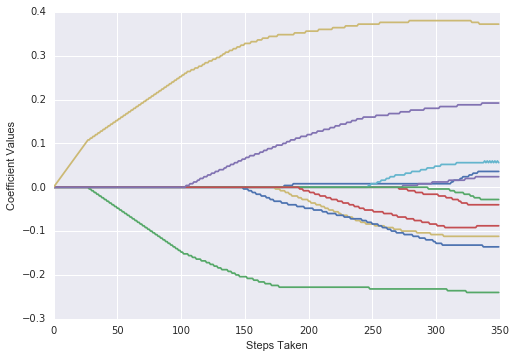

In [14]:
n_rows = len(df.index)
n_cols = len(x_list[0])
beta = [0.0] * n_cols # row of beta coefficients
beta_matrix = [] # matrix of beta coefficients
beta_matrix.append(list(beta))
n_steps = 350
step_size = 0.004
lars_indices = [] # features placement sequence

# calculate correlation between features & residuals
# and increment (decrement) beta corresponding to feature with highest correlation 
for i in range(n_steps):
    residuals = [0.0] * n_rows
    for j in range(n_rows):
        labels_hat = sum([x_scaled[j][k] * beta[k] for k in range(n_cols)])
        residuals[j] = labels_scaled[j] - labels_hat
    corr = [0.0] * n_cols    
    for j in range(n_cols):
        corr[j] = sum([x_scaled[k][j] * residuals[k] for k in range(n_rows)]) / n_rows
    k = 0    
    corr_i = corr[0]
    for j in range(1, (n_cols)):
        if abs(corr_i) < abs(corr[j]):
            k = j
            corr_i = corr[j]
    beta[k] += step_size * corr_i / abs(corr_i)
    beta_matrix.append(list(beta))
    beta_indices = [index for index in range(n_cols) if beta[index] != 0.0]
    for q in beta_indices:
        if (q in lars_indices) == False:
            lars_indices.append(q)

#find the beta matrix index with lowest rmse
errors = []
#x = np.array(df_scaled).tolist()  #list of list format for calc_pre_vals
#y = labels_scaled
for i in range(len(beta_matrix)):
    preds = calc_pred_vals(x_scaled, beta_matrix[i])
    rms_error = calc_rmse(preds, labels_scaled)
    errors.append(rms_error)
min_error = min(errors)
min_index = errors.index(min_error)
print 'index of betas with lowest rmse', min_index, '  minimum rmse', min_error
    
#plot range of beta values for each attribute
for i in range(n_cols):
    coeff_curve = [beta_matrix[k][i] for k in range(n_steps)]
    xaxis = range(n_steps)
    plt.plot(xaxis, coeff_curve)
print '\ncoefficients in original feature order'
dfnames = df.columns
coeffs = beta_matrix[min_index]
print (zip(dfnames, coeffs))  
lars_sequence = [dfnames[lars_indices[i]] for i in range(len(lars_indices))]  
lars_coeffs = [coeffs[i] for i in lars_indices]
print '\nfeature priority under LARS algorithm\n', lars_sequence
plt.xlabel("Steps Taken")
plt.ylabel(("Coefficient Values"))
plt.show()

#### 5. Lars, xy scaled

In [15]:
def run_lars_5(x, y):
    preds = calc_pred_vals(x, lars_coeffs)  # lars_coeffs is global; no intercept
    model_details('Lars, from scratch, xy scaled', preds, lars_coeffs, 0, lars_sequence, 
                  y, False)

#### 6. Lasso, alphas, sklearn

In [16]:
x = df_scaled[lars_sequence]
y = labels_scaled
alpha_list = [0.001, 0.01, 0.1]  
error_list = []
for alph in alpha_list:
    modl = Lasso(alpha=alph, normalize=False) 
    modl.fit(x, y)   
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    rms_error = calc_rmse(preds, y)  #calculate errors
    error_list.append(rms_error)
print 'x and y scaled'
print("RMS Error             alpha")
for i in range(len(error_list)):
    print(error_list[i], alpha_list[i])

y = df['target']
alpha_list = [0.001, 0.01, 0.1]  
error_list = []
for alph in alpha_list:
    modl = Lasso(alpha=alph, normalize=False) 
    modl.fit(x, y)   
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    rms_error = calc_rmse(preds, y)  #calculate errors
    error_list.append(rms_error)
print '\nx scaled  (labels not scaled)'
print("RMS Error             alpha")
for i in range(len(error_list)):
    print(error_list[i], alpha_list[i])

x and y scaled
RMS Error             alpha
(0.81708174767321784, 0.001)
(0.8160103265216736, 0.01)
(0.83789547968910716, 0.1)

x scaled  (labels not scaled)
RMS Error             alpha
(0.65963738656123083, 0.001)
(0.65863795393371882, 0.01)
(0.68208758146391235, 0.1)


#### 7. Lasso, alpha 0.01, sklearn, xy scaled 

In [17]:
def run_lasso_7(x, y):
    modl = Lasso(alpha=0.01, normalize=False)
    modl.fit(x,y)
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Lasso alpha 0.01, sklearn, xy scaled', preds, modl.coef_, 
                  modl.intercept_, lars_sequence, y, False)

#### 8. Lasso, alpha 0.01, sklearn, x scaled

In [18]:
def run_lasso_8(x, y):
    modl = Lasso(alpha=0.01, normalize=False)
    modl.fit(x,y)
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Lasso alpha 0.01, sklearn, x scaled', preds, modl.coef_, 
                  modl.intercept_, lars_sequence, y)

#### 9. Gradient Descent, from scratch, x scaled 

In [19]:
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    data = zip(x, y)
    theta = theta_0   # theta-initial guess
    alpha = alpha_0   # alpha-initial step size
    min_theta = None  # the minimum so far
    min_value = float("inf") 
    iterations_with_no_improvement = 0
    while iterations_with_no_improvement < 100: 
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)
        # if we've found a new minimum, remember it & go back to the original step size
        if value < min_value: 
            min_theta = theta
            min_value = value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:  # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9
        for x_i, y_i in in_random_order(data):
            # and take a gradient step for each of the data points
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = np.subtract(theta, np.multiply(alpha, gradient_i)) 
    return min_theta

def sqd_err_gradient(x_i, y_i, beta):  
    return [-2 * x_ij * regr_error(x_i, y_i, beta) for x_ij in x_i]

def sqd_err_regr(x_i, y_i, beta):  
    return regr_error(x_i, y_i, beta) ** 2

def estimate_beta_sgd(x, y):  
    beta_initial = [random.random() for x_i in x[0]]
    beta = minimize_stochastic(sqd_err_regr, sqd_err_gradient, x, y, beta_initial, 0.001)
    return beta

def run_gradient_descent_9(x, y):
    random.seed(0)
    beta = estimate_beta_sgd(x, y)
    preds = calc_pred_vals(x[:,1:], beta[1:], beta[0])
    coefs = beta[1:]
    coefs = [coefs[i] for i in stepwise_indices] #use stepwise sequence
    model_details('Gradient Descent, from scratch, x scaled', preds, coefs, 
                  beta[0], stepwise_sequence, y)

#### 10. Gradient Descent, sklearn, x scaled 

In [20]:
def run_gradient_descent_10(x, y):
    modl = SGDRegressor(penalty='none', random_state=0)
    modl.fit(x, y)
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Gradient Descent, sklearn, x scaled', preds, modl.coef_, 
                  modl.intercept_, stepwise_sequence, y)

#### 11. Gradient Descent 7 features, from scratch, x scaled 

In [21]:
def run_gr_des_11(x, y):
    random.seed(0)
    beta = estimate_beta_sgd(x, y)
    preds = calc_pred_vals(x[:,1:], beta[1:], beta[0])
    coefs = beta[1:]
    model_details('Gradient Descent 7 features, from scratch, x scaled', preds, coefs, 
                  beta[0], stepwise_sequence[0:7], y)

#### 12. Gradient Descent 7 features, sklearn, x scaled

In [22]:
def run_gradient_descent_12(x, y):
    modl = SGDRegressor(penalty='none', random_state=0)
    modl.fit(x, y) 
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Gradient Descent 7 features, sklearn, x scaled', preds, modl.coef_, 
                  modl.intercept_, stepwise_sequence[0:7], y)

#### 13. Ridge, alphas, from scratch, x scaled

In [23]:
def ridge_penalty(beta, alpha):
    return alpha * np.dot(beta[1:], beta[1:])

def ridge_penalty_gradient(beta, alpha):# gradient of just the ridge penalty
    return [0] + [2 * alpha * beta_j for beta_j in beta[1:]]

def sqd_err_ridge(x_i, y_i, beta, alpha): 
    # estimate error plus ridge penalty on beta
    return regr_error(x_i, y_i, beta) ** 2 + ridge_penalty(beta, alpha)

def sqd_err_ridge_gradient(x_i, y_i, beta, alpha): 
    # gradient corresponding to the ith squared error term incl the ridge penalty
    return np.add(sqd_err_gradient(x_i, y_i, beta), ridge_penalty_gradient(beta, alpha))

# use gradient descent to fit a ridge regression with penalty alpha
def estimate_beta_ridge(x, y, alpha): 
    beta_initial = [random.random() for x_i in x[0]]
    return minimize_stochastic(partial(sqd_err_ridge, alpha=alpha), 
                               partial(sqd_err_ridge_gradient, alpha=alpha), 
                               x, y, beta_initial, 0.001)

import random
x = sm.add_constant(x_scaled)
y = labels
random.seed(0)
print 'Ridge (alphas) from scratch, x scaled'
for alpha in [.00001, .0001, .001]:
    beta = estimate_beta_ridge(x, y, alpha=alpha)
    print '\nalpha:', alpha 
    print 'betas in original feature sequence\n', beta
    preds = calc_pred_vals(x[:,1:], beta[1:], beta[0])
    rdg_rmse = calc_rmse(preds, y)  
    print 'RMSE', rdg_rmse

Ridge (alphas) from scratch, x scaled

alpha: 1e-05
betas in original feature sequence
[ 5.63608395  0.04377114 -0.19372892 -0.03567816  0.02319853 -0.08850769
  0.0455746  -0.10737899 -0.0340782  -0.06365724  0.15534331  0.29410523]
RMSE 0.645575270098

alpha: 0.0001
betas in original feature sequence
[ 5.63619794  0.04379701 -0.19397906 -0.03554056  0.02308775 -0.08817093
  0.04591039 -0.10756145 -0.03380495 -0.06378187  0.15518923  0.29436765]
RMSE 0.645575192984

alpha: 0.001
betas in original feature sequence
[ 5.63575055  0.04392389 -0.19369303 -0.03525398  0.02313893 -0.08791062
  0.04556933 -0.10710525 -0.03432839 -0.06321561  0.15496523  0.29359623]
RMSE 0.645575579638


#### 14. Ridge, alphas, sklearn

In [24]:
x = df[stepwise_sequence]
y = df['target']
alpha_list = [0.1, 1, 10]  #use a range of alphas
error_list = []
for alph in alpha_list:
    modl = Ridge(alpha=alph) 
    modl.fit(x, y)   
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    rms_error = calc_rmse(preds, y)  #calculate errors
    error_list.append(rms_error)
print("RMS Error             alpha")
for i in range(len(error_list)):
    print(error_list[i], alpha_list[i])

RMS Error             alpha
(0.65895530384808398, 0.1)
(0.65888313822882527, 1)
(0.66101735274064799, 10)


#### 15. Ridge alpha .0001, from scratch, x scaled

In [25]:
def run_ridge_15(x, y):
    random.seed(0)
    beta = estimate_beta_ridge(x, y, alpha=.0001)
    preds = calc_pred_vals(x[:,1:], beta[1:], beta[0])
    coefs = beta[1:]
    coefs = [coefs[i] for i in stepwise_indices] 
    model_details('Ridge alpha .0001, from scratch, x scaled', preds, coefs, beta[0], 
                  stepwise_sequence, y)

#### 16. Ridge alpha 1, sklearn

In [26]:
def run_ridge_16(x, y):
    modl = Ridge(alpha=1)
    modl.fit(x, y) 
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Ridge alpha 1, sklearn', preds, modl.coef_, modl.intercept_, 
                  stepwise_sequence, y)

#### 17. ElasticNet grid search for L1 ratio

In [28]:
selected_cols = lars_sequence  
x = df_scaled[selected_cols]
y = labels_scaled
enet_p = {'l1_ratio' : [0, 1e-10, .1, .3, .5, .7, .9, 1]}                                    
enet = ElasticNet()                                   # instantiate model
enet_grid = GridSearchCV(enet, enet_p, cv=5)          # instantiate grid
enet_grid.fit(x, y)                                   # fit grid with data
print "best parameters: \n", enet_grid.best_params_   # print best parameters

best parameters: 
{'l1_ratio': 0}


#### Running Models

In [29]:
# create lists for storing details
modl_name = [] # name for model
rmse = [] # root mean square error
accuracy = [] # overall accuracy
cmats = [] # confusion matrix dataframe
cmat_sum = [] # to confirm no results are missing
df_beta_coefs = [] # coefficients dataframe

In [30]:
# results of Stepwise Algorithm #1 appear in prior section
run_stepwise_2(df[stepwise_sequence[0:7]], df['target'])

In [31]:
run_linear_regr_3(df[stepwise_sequence], df['target'])

In [32]:
#results of Lars Algorithm #4 appear in prior section
run_lars_5(np.array(df_scaled[lars_sequence]).tolist(), labels_scaled)

In [33]:
#results for Lasso alphas #6 appear in prior section
run_lasso_7(df_scaled[lars_sequence], labels_scaled)

In [34]:
run_lasso_8(df_scaled[lars_sequence], df['target'])

In [35]:
run_gradient_descent_9(sm.add_constant(x_scaled), labels)

In [36]:
run_gradient_descent_10(df_scaled[stepwise_sequence], df['target'])

In [37]:
run_gr_des_11(sm.add_constant(np.array(df_scaled[stepwise_sequence[0:7]]).tolist()), labels)

In [38]:
run_gradient_descent_12(df_scaled[stepwise_sequence[0:7]], df['target'])

In [39]:
#results for Ridge alphas #13 & #14 appear in prior section
run_ridge_15(sm.add_constant(x_scaled), labels)

In [40]:
run_ridge_16(df[stepwise_sequence], df['target'])

#### Model Scores

In [41]:
df_scores = pd.DataFrame(zip(rmse, accuracy), columns = ['RMSE', 'Overall Accuracy'], 
                         index = modl_name)
df_scores

,RMSE,Overall Accuracy
Stepwise Regression,0.656556,0.587242
Linear Regression,0.659660,0.589118
"Lars, from scratch, xy scaled",0.799686,"n/a, labels are scaled"
"Lasso alpha 0.01, sklearn, xy scaled",0.816010,"n/a, labels are scaled"
"Lasso alpha 0.01, sklearn, x scaled",0.658638,0.589118
"Gradient Descent, from scratch, x scaled",0.645575,0.59162
"Gradient Descent, sklearn, x scaled",0.659644,0.590994
"Gradient Descent 7 features, from scratch, x scaled",0.646121,0.592871
"Gradient Descent 7 features, sklearn, x scaled",0.656390,0.589744
"Ridge alpha .0001, from scratch, x scaled",0.645575,0.59162


Confirm all confusion matrix entries were picked up

In [42]:
cmat_sum

[1599,
 1599,
 'n/a, labels are scaled',
 'n/a, labels are scaled',
 1599,
 1599,
 1599,
 1599,
 1599,
 1599,
 1599]

#### Model Summaries

In [43]:
print 'RMSE', rmse[0]
df_beta_coefs[0]

RMSE 0.656556196539


,intercept,alcohol (10),volatile acidity (1),sulphates (9),chlorides (4),total sulfur dioxide (6),pH (8),free sulfur dioxide (5)
Stepwise Regression,4.4301,0.2893,-1.01275,0.88267,-2.01781,-0.00348,-0.48266,0.00508


In [44]:
print 'RMSE', rmse[1]
df_beta_coefs[1]

RMSE 0.659660460888


,intercept,alcohol (10),volatile acidity (1),sulphates (9),chlorides (4),total sulfur dioxide (6),pH (8),free sulfur dioxide (5),citric acid (2),residual sugar (3),density (7),fixed acidity (0)
Linear Regression,21.96521,0.2762,-1.08359,0.91633,-1.87423,-0.00326,-0.41365,0.00436,-0.18256,0.01633,-17.88116,0.02499


In [45]:
print 'RMSE', rmse[2]
df_beta_coefs[2]

RMSE 0.799685719012


,intercept,alcohol (10),volatile acidity (1),sulphates (9),total sulfur dioxide (6),chlorides (4),fixed acidity (0),pH (8),free sulfur dioxide (5),citric acid (2),residual sugar (3),density (7)
"Lars, from scratch, xy scaled",0.0,0.372,-0.24,0.192,-0.136,-0.112,0.036,-0.088,0.06,-0.04,0.024,-0.028


In [46]:
print 'RMSE', rmse[3]
df_beta_coefs[3]

RMSE 0.816010326522


,intercept,alcohol (10),volatile acidity (1),sulphates (9),total sulfur dioxide (6),chlorides (4),fixed acidity (0),pH (8),free sulfur dioxide (5),citric acid (2),residual sugar (3),density (7)
"Lasso alpha 0.01, sklearn, xy scaled",0.0,0.37649,-0.22697,0.17273,-0.11069,-0.10056,0.0,-0.07397,0.0333,-0.0,0.00287,-0.0


In [47]:
print 'RMSE', rmse[4]
df_beta_coefs[4]

RMSE 0.658637953934


,intercept,alcohol (10),volatile acidity (1),sulphates (9),total sulfur dioxide (6),chlorides (4),fixed acidity (0),pH (8),free sulfur dioxide (5),citric acid (2),residual sugar (3),density (7)
"Lasso alpha 0.01, sklearn, x scaled",5.63602,0.30325,-0.18364,0.13688,-0.083,-0.07773,0.0,-0.05646,0.02091,-0.0,0.00035,-0.0


In [48]:
print 'RMSE', rmse[5]
df_beta_coefs[5]

RMSE 0.645575269722


,intercept,alcohol (10),volatile acidity (1),sulphates (9),chlorides (4),total sulfur dioxide (6),pH (8),free sulfur dioxide (5),citric acid (2),residual sugar (3),density (7),fixed acidity (0)
"Gradient Descent, from scratch, x scaled",5.63608,0.29411,-0.19373,0.15534,-0.08851,-0.10738,-0.06366,0.04558,-0.03568,0.0232,-0.03407,0.04377


In [49]:
print 'RMSE', rmse[6]
df_beta_coefs[6]

RMSE 0.659643540989


,intercept,alcohol (10),volatile acidity (1),sulphates (9),chlorides (4),total sulfur dioxide (6),pH (8),free sulfur dioxide (5),citric acid (2),residual sugar (3),density (7),fixed acidity (0)
"Gradient Descent, sklearn, x scaled",5.63146,0.29765,-0.18752,0.15409,-0.10259,-0.10222,-0.06106,0.05149,-0.02868,0.02585,-0.04763,0.03462


In [50]:
print 'RMSE', rmse[7]
df_beta_coefs[7]

RMSE 0.64612051279


,intercept,alcohol (10),volatile acidity (1),sulphates (9),chlorides (4),total sulfur dioxide (6),pH (8),free sulfur dioxide (5)
"Gradient Descent 7 features, from scratch, x scaled",5.63607,0.30813,-0.18165,0.14945,-0.09477,-0.11436,-0.07447,0.05298


In [51]:
print 'RMSE', rmse[8]
df_beta_coefs[8]

RMSE 0.656390405034


,intercept,alcohol (10),volatile acidity (1),sulphates (9),chlorides (4),total sulfur dioxide (6),pH (8),free sulfur dioxide (5)
"Gradient Descent 7 features, sklearn, x scaled",5.63145,0.3185,-0.17996,0.14468,-0.1087,-0.10275,-0.07146,0.05644


In [52]:
print 'RMSE', rmse[9]
df_beta_coefs[9]

RMSE 0.64557524728


,intercept,alcohol (10),volatile acidity (1),sulphates (9),chlorides (4),total sulfur dioxide (6),pH (8),free sulfur dioxide (5),citric acid (2),residual sugar (3),density (7),fixed acidity (0)
"Ridge alpha .0001, from scratch, x scaled",5.63605,0.29432,-0.19387,0.15559,-0.08832,-0.10715,-0.06378,0.04548,-0.03527,0.023,-0.03394,0.04364


In [53]:
print 'RMSE', rmse[10]
df_beta_coefs[10]

RMSE 0.658883138229


,intercept,alcohol (10),volatile acidity (1),sulphates (9),chlorides (4),total sulfur dioxide (6),pH (8),free sulfur dioxide (5),citric acid (2),residual sugar (3),density (7),fixed acidity (0)
"Ridge alpha 1, sklearn",4.16024,0.29834,-1.10607,0.81781,-1.34485,-0.00322,-0.43769,0.00449,-0.19833,0.00754,-0.02068,0.01348


#### Confusion Matrices & Overall Accuracy

In [54]:
print modl_name[0]
print 'overall accuracy:', accuracy[0]
cmats[0]

Stepwise Regression
overall accuracy: 0.587242026266


,P3,P4,P5,P6,P7,P8,Total
A3,0,1,8,1,0,0,10
A4,0,1,31,21,0,0,53
A5,0,2,479,196,4,0,681
A6,0,0,189,423,26,0,638
A7,0,0,7,156,36,0,199
A8,0,0,0,12,6,0,18


In [55]:
print modl_name[1]
print 'overall accuracy:', accuracy[1]
cmats[1]

Linear Regression
overall accuracy: 0.589118198874


,P3,P4,P5,P6,P7,P8,Total
A3,0,1,8,1,0,0,10
A4,0,1,33,19,0,0,53
A5,0,3,475,199,3,1,681
A6,0,0,185,429,24,0,638
A7,0,0,9,153,37,0,199
A8,0,0,0,12,6,0,18


In [56]:
print modl_name[4]
print 'overall accuracy:', accuracy[4]
cmats[4]

Lasso alpha 0.01, sklearn, x scaled
overall accuracy: 0.589118198874


,P3,P4,P5,P6,P7,P8,Total
A3,0,1,8,1,0,0,10
A4,0,0,32,21,0,0,53
A5,0,2,480,197,2,0,681
A6,0,0,186,434,18,0,638
A7,0,0,7,164,28,0,199
A8,0,0,0,12,6,0,18


In [57]:
print modl_name[5]
print 'overall accuracy:', accuracy[5]
cmats[5]

Gradient Descent, from scratch, x scaled
overall accuracy: 0.591619762351


,P3,P4,P5,P6,P7,P8,Total
A3,0,1,8,1,0,0,10
A4,0,1,34,18,0,0,53
A5,0,3,477,197,4,0,681
A6,0,0,183,428,27,0,638
A7,0,0,7,152,40,0,199
A8,0,0,0,11,7,0,18


In [58]:
print modl_name[6]
print 'overall accuracy:', accuracy[6]
cmats[6]

Gradient Descent, sklearn, x scaled
overall accuracy: 0.590994371482


,P3,P4,P5,P6,P7,P8,Total
A3,0,1,8,1,0,0,10
A4,0,1,32,20,0,0,53
A5,0,3,485,190,3,0,681
A6,0,0,195,417,26,0,638
A7,0,0,8,149,42,0,199
A8,0,0,0,11,7,0,18


In [59]:
print modl_name[7]
print 'overall accuracy:', accuracy[7]
cmats[7]

Gradient Descent 7 features, from scratch, x scaled
overall accuracy: 0.59287054409


,P3,P4,P5,P6,P7,P8,Total
A3,0,1,8,1,0,0,10
A4,0,1,33,19,0,0,53
A5,0,2,480,195,4,0,681
A6,0,0,185,426,27,0,638
A7,0,0,7,151,41,0,199
A8,0,0,0,10,8,0,18


In [60]:
print modl_name[8]
print 'overall accuracy:', accuracy[8]
cmats[8]

Gradient Descent 7 features, sklearn, x scaled
overall accuracy: 0.589743589744


,P3,P4,P5,P6,P7,P8,Total
A3,0,1,8,1,0,0,10
A4,0,1,32,20,0,0,53
A5,0,3,479,196,3,0,681
A6,0,0,192,419,27,0,638
A7,0,0,8,147,44,0,199
A8,0,0,0,11,7,0,18


In [61]:
print modl_name[9]
print 'overall accuracy:', accuracy[9]
cmats[9]

Ridge alpha .0001, from scratch, x scaled
overall accuracy: 0.591619762351


,P3,P4,P5,P6,P7,P8,Total
A3,0,1,8,1,0,0,10
A4,0,1,34,18,0,0,53
A5,0,3,477,197,4,0,681
A6,0,0,183,428,27,0,638
A7,0,0,7,152,40,0,199
A8,0,0,0,11,7,0,18


In [62]:
print modl_name[10]
print 'overall accuracy:', accuracy[10]
cmats[10]

Ridge alpha 1, sklearn
overall accuracy: 0.587867417136


,P3,P4,P5,P6,P7,P8,Total
A3,0,1,8,1,0,0,10
A4,0,1,33,19,0,0,53
A5,0,3,479,196,2,1,681
A6,0,0,187,429,22,0,638
A7,0,0,6,162,31,0,199
A8,0,0,0,12,6,0,18
